In [1]:
import glob
import scipy.interpolate
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

This isn't coded in the best way, but first I run the signal energies (From MC_neutrino_data) through this and save it, then I run the background energies through this. 

71766 71766 71766


(array([4077., 3926., 4332., 4074., 3134., 1935., 1000.,  544.,  156.,
          38.]),
 array([2.99504705, 3.33398724, 3.67292744, 4.01186763, 4.35080783,
        4.68974802, 5.02868822, 5.36762841, 5.70656861, 6.0455088 ,
        6.384449  ]),
 <BarContainer object of 10 artists>)

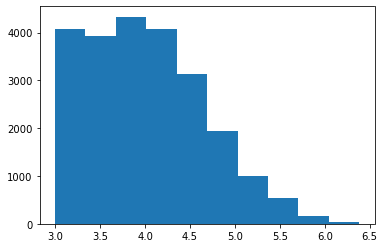

In [39]:

##Load smearing data from IceCube
data_file = "./data/IC86_II_smearing.csv"
e_nu = np.array([])
e_mu = np.array([])
dec = np.array([])
frac = np.array([])
df = pd.DataFrame()    
df = pd.concat([df, pd.read_fwf(data_file, header=None, skiprows=1)])

e_nu = (df[0].to_numpy()+df[1].to_numpy())/2
e_mu = (df[4].to_numpy()+df[5].to_numpy())/2
dec =  (df[2].to_numpy()+df[3].to_numpy())/2
frac = (df[10].to_numpy())


e_nu = np.delete(e_nu, e_mu==0)
dec = np.delete(dec, e_mu==0)
frac = np.delete(frac, e_mu==0)
e_mu = np.delete(e_mu, e_mu==0)

#Comment out if generating signal 

icecube_data = np.load("./processed_data/background_energies.npz",
                       allow_pickle=True)
data_dec = np.array(icecube_data["background_dec"])
data_eng = np.array(icecube_data["background_eng"])
data_ra = np.array(icecube_data["background_ra"])



""" 

icecube_data = np.load("./processed_data/signal_energies.npz",
                       allow_pickle=True)
data_dec = np.array(icecube_data["signal_dec"])
data_eng = np.array(icecube_data["signal_eng"])
data_ra = np.array(icecube_data["signal_ra"])
"""

print(len(data_dec),len(data_eng),len(data_ra))

north_eng = np.zeros(len(data_eng[data_dec>=10]))
horizon_eng = np.zeros(len(data_eng[np.logical_and(data_dec>=-10,data_dec<10)]))
south_eng = np.zeros(len(data_eng[data_dec>=10]))

north_eng = data_eng[data_dec>=10]
horizon_eng = data_eng[np.logical_and(data_dec>=-10,data_dec<10)]
south_eng = data_eng[data_dec<-10]

plt.hist(south_eng)

[2.25 2.75 3.25 3.75 4.25 4.75 5.25 5.75 6.25 6.75 7.25 7.75 8.25 8.75]


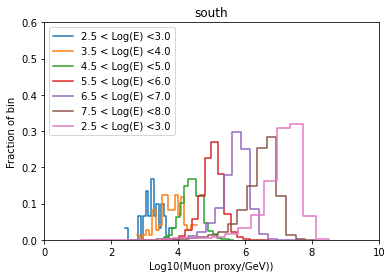

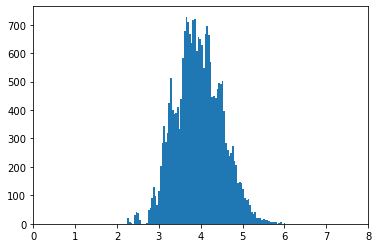

23216


In [41]:

##Find the indices of the smearing data of the south, and set new variables of neutrino, muon, and fractional
##data for those indices. Lim is the average of the bounds for neutrino energy


index = []
for i in range(len(dec)):
    if dec[i]<-10:
        index.insert(len(index),i)
lim = [2.25, 2.75, 3.25,3.75,4.25,4.75,5.25,5.75,6.25,6.75,7.25,7.75,8.25,8.75]
regional_e_mu = e_mu[index]
regional_e_nu = e_nu[index]
regional_frac = frac[index]
alphs = [1,.9,.85,.8,.7,.65,.6,.5,.4,.35,.3,.2,.1]

print(np.unique(regional_e_nu))

##Here I define variables of the unique muon energy bins in the IceCube data (mainly for plot recreation)
##Then, I define total_frac, which sums over the fractional value of each individual data point. 
##Next is new_e_mu, which is where I will store the muon energy converted from neutrino energy.
##Muon is the linspace to create the function over, where the bounds are the min and max of the distribution given

unique_mu = np.zeros((14,20))
total_frac = np.zeros((14,20))
new_e_mu = np.zeros(len(south_eng))
lower_bound = [2.0, 2.5, 3.0, 3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5]
upper_bound = [2.5, 3.0, 3.5, 4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0]
label = ["2.5 < Log(E) <3.0",
         "2.5 < Log(E) <3.0",
         "2.5 < Log(E) <3.0",
         "3.5 < Log(E) <4.0",
         "2.5 < Log(E) <3.0",
         "4.5 < Log(E) <5.0",
         "2.5 < Log(E) <3.0",
         "5.5 < Log(E) <6.0",
         "2.5 < Log(E) <3.0",
         "6.5 < Log(E) <7.0",
         "2.5 < Log(E) <3.0",
         "7.5 < Log(E) <8.0",
         "2.5 < Log(E) <3.0",
         "2.5 < Log(E) <3.0"]
muon = np.zeros((14,1000))
for k in range(len(lim)):
    if regional_e_nu.any()==lim[k]:
        print("hi")
    unique_mu[k] = np.unique(regional_e_mu[regional_e_nu==lim[k]])
    for i, unique in enumerate(unique_mu[k]):
        total_frac[k][i] = np.sum(regional_frac[unique==regional_e_mu])
    
    if (k % 2) != 0:   
        plt.step(unique_mu[k],total_frac[k], label = label[k])
        plt.xlim(0,10)
        plt.ylim(0,0.6)
        plt.legend()
        plt.xlabel("Log10(Muon proxy/GeV))")
        plt.ylabel("Fraction of bin")
        plt.title("south")
    muon[k]=np.linspace(np.min(unique_mu[k]),np.max(unique_mu[k]),1000)
    func = scipy.interpolate.interp1d(unique_mu[k], total_frac[k], bounds_error=False, fill_value=0)
    new_e_mu[np.logical_and(south_eng<upper_bound[k],south_eng>=lower_bound[k])] = np.random.choice(muon[k],
                                                                                                      p = (func(muon[k])/np.sum(func(muon[k]))),
                                                                                                      size = len(new_e_mu[np.logical_and(south_eng<upper_bound[k],south_eng>=lower_bound[k])]))
plt.show()
plt.hist(new_e_mu, bins = 100)
plt.xlim(0,8)
plt.show()
data_eng[data_dec<-10] = new_e_mu
print(len(new_e_mu))

2.995047045446462


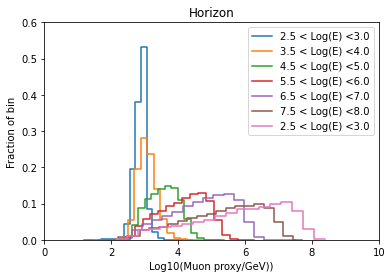

17209


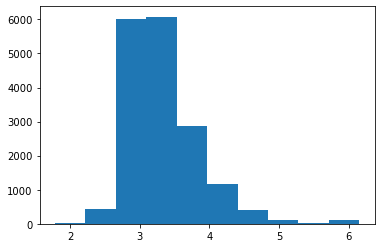

In [42]:

##Find the indices of the smearing data of the Horizon, and set new variables of neutrino, muon, and fractional
##data for those indices. Lim is the average of the bounds for neutrino energy


index = []
for i in range(len(dec)):
    if np.logical_and(dec[i]>= -10, dec[i]<10):
        index.insert(len(index),i)
lim = [2.25,2.75,3.25,3.75,4.25,4.75,5.25,5.75,6.25,6.75,7.25,7.75,8.25,8.75]
regional_e_mu = e_mu[index]
regional_e_nu = e_nu[index]
regional_frac = frac[index]
label = ["2.5 < Log(E) <3.0",
         "2.5 < Log(E) <3.0",
         "2.5 < Log(E) <3.0",
         "3.5 < Log(E) <4.0",
         "2.5 < Log(E) <3.0",
         "4.5 < Log(E) <5.0",
         "2.5 < Log(E) <3.0",
         "5.5 < Log(E) <6.0",
         "2.5 < Log(E) <3.0",
         "6.5 < Log(E) <7.0",
         "2.5 < Log(E) <3.0",
         "7.5 < Log(E) <8.0",
         "2.5 < Log(E) <3.0",
         "2.5 < Log(E) <3.0"]




##Here I define variables of the unique muon energy bins in the IceCube data (mainly for plot recreation)
##Then, I define total_frac, which sums over the fractional value of each individual data point. 
##Next is new_e_mu, which is where I will store the muon energy converted from neutrino energy.
##Muon is the linspace to create the function over, where the bounds are the min and max of the distribution given

unique_mu = np.zeros((14,20))
total_frac = np.zeros((14,20))
new_e_mu = np.ones(len(horizon_eng))
print(np.min(horizon_eng))
lower_bound = [2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5]
upper_bound = [2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0]
muon = np.zeros((14,1000))

for k in range(len(lim)):
    unique_mu[k] = np.unique(regional_e_mu[regional_e_nu==lim[k]])
    for i, unique in enumerate(unique_mu[k]):
        total_frac[k][i] = np.sum(regional_frac[unique==regional_e_mu])
    if (k% 2)  !=0:    
        plt.step(unique_mu[k],total_frac[k],label = label[k])
        plt.xlim(0,10)
        plt.ylim(0,0.6)
        plt.legend()
        plt.xlabel("Log10(Muon proxy/GeV))")
        plt.ylabel("Fraction of bin")
        plt.title("Horizon")
    muon[k]=np.linspace(np.min(unique_mu[k]),np.max(unique_mu[k]),1000)
    func = scipy.interpolate.interp1d(unique_mu[k], total_frac[k], bounds_error=False, fill_value=0)
    new_e_mu[np.logical_and(horizon_eng<upper_bound[k],horizon_eng>=lower_bound[k])] = np.random.choice(muon[k],
                                                                                                      p = (func(muon[k])/np.sum(func(muon[k]))),
                                                                                                      size = len(new_e_mu[np.logical_and(horizon_eng<upper_bound[k],horizon_eng>=lower_bound[k])]))

plt.show()
plt.hist(new_e_mu)
print(len(new_e_mu))
data_eng[np.logical_and(data_dec>= -10,data_dec<10)] = new_e_mu


1.155
1.1495
1.2195
1.2875
1.319
1.5070000000000001
1.581
1.492
1.4015
1.496
1.492
1.939
1.7905
2.3165


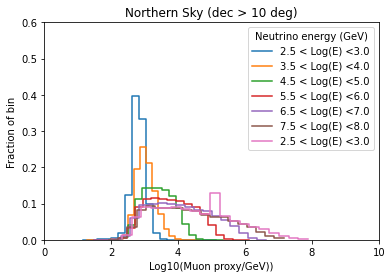

31341


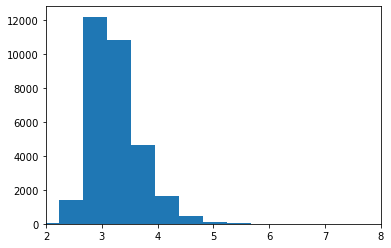

In [45]:
index = []
for i in range(len(dec)):
    if dec[i] >=10:
        index.insert(len(index),i)
lim = [2.25,2.75,3.25,3.75,4.25,4.75,5.25,5.75,6.25,6.75,7.25,7.75,8.25,8.75]
regional_e_mu = e_mu[index]
regional_e_nu = e_nu[index]
regional_frac = frac[index]
label = ["2.5 < Log(E) <3.0",
         "2.5 < Log(E) <3.0",
         "2.5 < Log(E) <3.0",
         "3.5 < Log(E) <4.0",
         "2.5 < Log(E) <3.0",
         "4.5 < Log(E) <5.0",
         "2.5 < Log(E) <3.0",
         "5.5 < Log(E) <6.0",
         "2.5 < Log(E) <3.0",
         "6.5 < Log(E) <7.0",
         "2.5 < Log(E) <3.0",
         "7.5 < Log(E) <8.0",
         "2.5 < Log(E) <3.0",
         "2.5 < Log(E) <3.0"]




##Here I define variables of the unique muon energy bins in the IceCube data (mainly for plot recreation)
##Then, I define total_frac, which sums over the fractional value of each individual data point. 
##Next is new_e_mu, which is where I will store the muon energy converted from neutrino energy.
##Muon is the linspace to create the function over, where the bounds are the min and max of the distribution given

unique_mu = np.zeros((14,20))
total_frac = np.zeros((14,20))
new_e_mu = np.zeros(len(north_eng))
lower_bound = [2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5]
upper_bound = [2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0]
muon = np.zeros((14,1000))

for k in range(len(lim)):
    unique_mu[k] = np.unique(regional_e_mu[regional_e_nu==lim[k]])
    for i, unique in enumerate(unique_mu[k]):
        total_frac[k][i] = np.sum(regional_frac[unique==regional_e_mu])
    if (k % 2) != 0:    
        plt.step(unique_mu[k],total_frac[k],label = label[k])
        plt.xlim(0,10)
        plt.ylim(0,0.6)
        legend = plt.legend()
        plt.xlabel("Log10(Muon proxy/GeV))")
        plt.ylabel("Fraction of bin")
        plt.title("Northern Sky (dec > 10 deg)")
    muon[k]=np.linspace(np.min(unique_mu[k]),np.max(unique_mu[k]),1000)
    print(np.min(unique_mu[k]))
    func = scipy.interpolate.interp1d(unique_mu[k], total_frac[k], bounds_error=False, fill_value=0)
    new_e_mu[np.logical_and(north_eng<upper_bound[k],north_eng>=lower_bound[k])] = np.random.choice(muon[k],
                                                                                                      p = (func(muon[k])/np.sum(func(muon[k]))),
                                                                                                      size = len(new_e_mu[np.logical_and(north_eng<upper_bound[k],north_eng>=lower_bound[k])]))
legend.set_title("Neutrino energy (GeV)")
plt.show()
print(len(new_e_mu))
plt.hist(new_e_mu)
plt.xlim(2,8)
data_eng[data_dec>=10] = new_e_mu


In [63]:
np.savez("./processed_data/background_energies_muon.npz",
        data_eng = data_eng,
        data_dec = data_dec,
        data_ra = data_ra)

"""
np.savez("./processed_data/signal_energies_muon.npz",
        data_eng = data_eng,
        data_dec = data_dec,
        data_ra = data_ra)

"""